###Common definitions

In [ ]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras

import random
import simpy
import scipy
import numpy as np
from scipy.stats import bernoulli

import matplotlib
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Activation,Flatten 
from keras.models import Sequential, load_model
from keras.optimizers import Adam


time_slot = 20

#resource requirement for each task r^k_m


#Beta = np.array([0.5, 0.5]) #geometric distribution parameter

#Lambda = np.array([0.3,0.3]) #iid Bernoulli process parameter



RANDOM_SEED = 42




K = 5;
M = 5; 
#action = np.array(np.zeros(M)) #action matrix for RL, 0 is don't process, 1 is process
#r = np.random.randint(3,5,(M,K))
r = np.zeros((M,K))
for i in range(M):
  for j in range(K):
    r[i,j] = i+1
#r = np.random.randint(1,5,(M,K))

C_k = np.random.randint(10,15,K)

#Beta = np.random.rand(M)
Beta = np.array([0.1, 0.1, 0.1,0.1, 0.1])
#Lambda = np.random.rand(M)
Lambda = Beta
#U = np.random.randint(5,20,M)#reward per task
U = np.array([50,40,30,20,10])
print(r," resource required per task per type")
print(U," reward per task")
print(Beta," geometric processing time parameter")
print(Lambda," Bernoulli processing arrival parameter")
print(C_k," global resources of type K")

[[1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2.]
 [3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4.]
 [5. 5. 5. 5. 5.]]  resource required per task per type
[50 40 30 20 10]  reward per task
[0.1 0.1 0.1 0.1 0.1]  geometric processing time parameter
[0.1 0.1 0.1 0.1 0.1]  Bernoulli processing arrival parameter
[10 10 10 12 10]  global resources of type K


In [ ]:
timeslot_duration = 10

num_timeslot = 500
num_timeslot_per_episode = 500
episode = 40

In [ ]:
RR_ratio = np.zeros((M,K))
for i in range(M):
  for j in range(K):
    RR_ratio[i,j] = U[i]/r[i,j]
print(RR_ratio,"is Reward resource ratio")

[[50. 50. 50. 50. 50.]
 [20. 20. 20. 20. 20.]
 [10. 10. 10. 10. 10.]
 [ 5.  5.  5.  5.  5.]
 [ 2.  2.  2.  2.  2.]] is Reward resource ratio


In [ ]:
!pip install simpy
import simpy

In [ ]:
def convert_RL_sim_action(rl_action,M):

  """
  rl_action is the output of q_values from the neural network 
  returned is the action that can be interpreted by simpy
  """

  b_action = np.binary_repr(rl_action,width=M)
  #print("binary repr of action is:",b_action)
  L = list(b_action)
  #print("binary list of action is:",L)
  true_action = np.array(L, dtype=int)
  return true_action

In [ ]:
def state_gen(b,m,r,common_resource):
    gen = []
    C = []
    
    for i in range (K):
      tmp = common_resource[i].level#occupies the resource for processing
      C.append(tmp)
    for k in range(M):
      tmp = bernoulli.rvs(Lambda[k])
      gen.append(tmp)
    new_gen = []
    for j in range (K):
      tmp = gen
      new_gen.append(gen)

    new_gen = np.array(new_gen)
    new_gen = np.transpose(new_gen)

    state = new_gen*r
    state = np.append(state, [C], axis=0)
    return state,gen



##MARL specific classes

In [ ]:
class ReplayBuffer_MARL(object):
  #def __init__(self,max_size,input_shape,input1,input2,n_actions):
  def __init__(self,max_size,input_shape,input1,n_actions):
    self.memsize = max_size
    self.mem_cntr = 0 
    self.state_memory = np.zeros((self.memsize,input1))
    self.new_state_memory = np.zeros((self.memsize,input1))
    self.action_memory = np.zeros((self.memsize), dtype= np.int8)
    self.reward_memory = np.zeros(self.memsize)


  def store_transistion(self,state,action,reward,newstate):
    index = self.mem_cntr % self.memsize
    self.state_memory[index] = state
    self.new_state_memory[index] = newstate
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr, self.memsize)
    batch = np.random.choice(max_mem,batch_size)

    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    return states,actions,rewards,new_states

In [ ]:
class MARL_Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size, input_dims, input1,mem_size=1000000,epsilon_dec=1e-3, epsilon_end=0.01, ):
        self.action_space = [i for i in range(2**M)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        #self.memory = ReplayBuffer(mem_size, input_dims,input1,input2,n_actions)
        self.memory = ReplayBuffer_MARL(mem_size, input_dims,input1,n_actions)
        self.q_eval = create_q_model_MARL(lr, n_actions, input1, 64, 64)
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end

    def store_transistion(self, state, action, reward, new_state):
        self.memory.store_transistion(state, action, reward, new_state)

    def choose_action(self, state,M):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
            #print("random action taken",action)
            #true = self.convert_RL_sim_action(action,M)

            return action
        else:
            #print(state,"is state for random action prediction")
            state = np.array([state])
            actions = self.q_eval.predict(state)

            action = np.argmax(actions)
            #print("action produced by Neural network")
            #t_action = self.convert_RL_sim_action(action)
            #true = self.convert_RL_sim_action(action,M)

            return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
          #dont learn because the replay buffer is not enough
          return

        states, actions, rewards, states_ = \
                self.memory.sample_buffer(self.batch_size)

        #output is bunch of actions
        #print(type(self.q_eval))
        q_eval = self.q_eval.predict(states) #calculate current state action
        q_next = self.q_eval.predict(states_) #calculate next state action


        q_target = np.copy(q_eval) #4 values with different weightings
        batch_index = np.arange(self.batch_size, dtype=np.int32)#
       # print(actions," is actions, ",actions.shape,"is actions shape",q_target.shape,"is q target shape")
        #update bellman's reward equation
        q_target[batch_index, actions] = rewards + \
                        self.gamma * np.max(q_next, axis=1)  #np.max determines the most likely action


        self.q_eval.train_on_batch(states, q_target)

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [ ]:
def create_q_model_MARL(lr, n_actions, input1, fc1_dims, fc2_dims):
    # Multi agent case input shape should be 1 dimension only
  model = Sequential([
                Flatten(input_shape=(input1,1)),
                Dense(fc1_dims),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
  return model

In [ ]:
class MARL_env(object):
  #aim of this class is to simulate a complete timeslot DES
  def __init__(self,env,num_timeslot,timeslot_duration,common_resource,counter,RR_ratio):
    self.reward = 0 #reward per task
    self.rewards_per_slot = 0
    self.timeslot_duration = timeslot_duration
    self.common_resource = common_resource
    #self.env = simpy.Environment()
    self.env = env
    self.counter = counter
    #self.counter = simpy.Resource(env, capacity=2*M)
    self.num_timeslot = num_timeslot
    self.timeslot_duration = timeslot_duration
    self.agent_reward_per_slot = np.zeros(K)
    self.RR_ratio = RR_ratio

  def interact_with_agent_1(self, env, agent, state):

    agent_action = agent.choose_action(state,M) #returns the action that can be interpreted in simpy!! carefull  
    #true_action = convert_RL_sim_action(agent_action,M)
    #return agent_action, true_action
    return agent_action

  def slot(self, counter, gen, agent1, agent2, agent3, agent4, agent5, score, state, reward_sum, reward_sum_history,agent_reward_history):
    """timeslot,generate the arrival of M different tasks, for one episode"""

    for i in range(self.num_timeslot):
      self.rewards_per_slot = 0
      self.reward = 0
      self.agent_reward_per_slot = np.zeros(K)

      agent_state0 = reduce_input_dim(state,0)#used for agent input state
      action1 = self.interact_with_agent_1(env,agent1,agent_state0)
      state1 = inter_agent_transistion(state,action1)#global state is not changed

      agent_state1 = reduce_input_dim(state1,1)
      action2 = self.interact_with_agent_1(env,agent2,agent_state1)
      state2 = inter_agent_transistion(state1,action2)

      agent_state2 = reduce_input_dim(state2,2)
      action3 = self.interact_with_agent_1(env,agent3,agent_state2)
      state3 = inter_agent_transistion(state2,action3)


      agent_state3 = reduce_input_dim(state3,3)
      action4 = self.interact_with_agent_1(env,agent4,agent_state3)
      state4 = inter_agent_transistion(state3,action4)

      agent_state4 = reduce_input_dim(state4,4)
      action5 = self.interact_with_agent_1(env,agent5,agent_state4)
      #state5 = inter_agent_transistion(state4,action5)
      #state5 is not used by other agent hence not useful


      true_action = convert_RL_sim_action(action5,M)

      for j in range(M):
        
        if gen[j]:  
          #print("generate tasks")
          self.env.process(  self.task_arrival(env, 'timelsot No. %02d, task %01d' % (i,j), self.counter,  true_action, j) )
          
        else:
          pass
      yield self.env.timeout(self.timeslot_duration)
      reward_sum += self.rewards_per_slot

      #need to fix agent_reward_per_slot!!!!
      agent_r = self.agent_reward_per_slot
      agent_reward_history.append(agent_r)
      reward = self.rewards_per_slot
      #print("a_r_perslot is:",agent_r)

      score.append(reward)
      new_state,gen = state_gen(Beta,M,r,common)

      """questionable of stroing transistion with the new state value??"""
      #do some prediction that can be used by next agent
      new_agent_state0 = reduce_input_dim(new_state,0)
      agent1.store_transistion(agent_state0,action1,agent_r[0],new_agent_state0)
      action1 = self.interact_with_agent_1(env,agent1,new_agent_state0)
      new_state1 = inter_agent_transistion(new_state,action1)


      new_agent_state1 = reduce_input_dim(new_state1,1)
      agent2.store_transistion(agent_state1,action2,agent_r[1],new_agent_state1)
      action2 = self.interact_with_agent_1(env,agent2,new_agent_state1)
      new_state2 = inter_agent_transistion(new_state1,action2)


      new_agent_state2 = reduce_input_dim(new_state2,2)
      agent3.store_transistion(agent_state2,action3,agent_r[2],new_agent_state2)
      action3 = self.interact_with_agent_1(env,agent3,new_agent_state2)
      new_state3 = inter_agent_transistion(new_state2,action3)


      new_agent_state3 = reduce_input_dim(new_state3,3)
      agent4.store_transistion(agent_state3,action4,agent_r[3],new_agent_state3)
      action4 = self.interact_with_agent_1(env,agent1,new_agent_state3)
      new_state4 = inter_agent_transistion(new_state3,action4)


      new_agent_state4 = reduce_input_dim(new_state4,4)
      agent5.store_transistion(agent_state4,action5,agent_r[4],new_agent_state4)



      state = new_state
      agent1.learn()
      agent2.learn()
      agent3.learn()
      agent4.learn()
      agent5.learn()


      #new_state,gen = self.interact_with_agent_2( env, agent,score, state,agent_action)
      #state = new_state

    reward_sum_history.append(reward_sum)

    #print("rewards is :",self.rewards_per_slot,"reward ",self.reward)
    
    #yield self.env.timeout(interval) 
  
  def task_arrival(self, env, name, counter,  action, m):
    """
    For a single task M, figure out whether to process it or not
    with action vector
    also need to return status of whether the task was sucessful or not
    """
    arrive = self.env.now
    #print('%7.4f %s: Task arrives' % (arrive, name))

    with counter.request() as req:  #performing certain a single task m

        #use action vector to check if this task
        allocate = True
        if action[m] == 0 :
          allocate = False
          #print('%7.4f %s: Action is not to process' % (env.now, name))

        if allocate:
          check = True
        
          #make use of action vector so that uncessary checks are obmitted
          for i in range(0,K):
            if self.common_resource[i].level < r[m,i]:
              #print('%7.4f %s: %1d %1d resource not satisfied for type: %1d'% (env.now,name, common_resource[i].level , r[i,1],i))
              print('%7.4f %s: resource not satisified, need resource %d, have resource %d' % (env.now, name,r[i,1],self.common_resource[i].level))
              check = False
              self.reward = 0

        
          """Starts processing if resource requiremenet is satisfied"""
          if check == True:
            
            for i in range (0,K):
              self.common_resource[i].get(r[m,i])#occupies the resource for processing
            #determines the length of processing
            tib = np.random.geometric(Beta[m])
            #t = 11
            yield env.timeout(tib)
            #print('%7.4f %s: Finished Processing' % (env.now, name))
            self.reward = U[m] #sucessfully allocated
            self.rewards_per_slot += self.reward
            #print("reward is:",self.reward)
            for i in range (0,K):
              self.agent_reward_per_slot[i] += self.RR_ratio[m,i]
              yield self.common_resource[i].put(r[m,i])#release the resources
            #time_left
            #print('%7.4f %s: Task resource released' % (env.now, name))
            
          

          else:
            #the resource does not satisfy, don't do this task.
            self.reward = 0 #sucessfully allocated
            yield env.timeout(0)

            #print('%7.4f %s: allocation failed' % (env.now, name))
    

  
  def interact_with_agent_2(self, env, agent,score,state,agent_action):
    #state = 0
    eps_history.append(agent.epsilon)
    #env.run() executed in the main program

    reward = rl_env.rewards_per_slot
    
    #print(reward," is reward for timeslot")
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,agent_action,reward,new_state)
    
    agent.learn()
    state = new_state
    
    return state,gen


In [ ]:
def inter_agent_transistion(state,action):
  """
  Change the state info based on the action provided 
  (e.g. The first agent only allow first two tasks to be processed, 
  the corresponding state would only have resource for the first two tasks, 
  all other tasks' resource requirement will be set to zero)
  """
  env_action = convert_RL_sim_action(action,M) #convert to binary array actions
  for i in range(M):
    if env_action[i] == 0:
      #if the action from the agent is drop this task, let the resource requirement be zero for that task
      for j in range(K):
        state[i,j] = 0
  return state


def reduce_input_dim(state,index):
  """
  Reduce the input neurons for each DQN agent to size of M+1, representing the partially observed env
  with the index given, it only displays the resource requirement for resource type K.
  index should be within the range of 0-4
  """
  partial_state = np.zeros(M+1)
  for i in range(M+1):
    partial_state[i] = state[i,index]
  return partial_state

###MARL execution program

In [ ]:
random.seed(RANDOM_SEED)

env = simpy.Environment()
#timeslot_duration = 10

#num_timeslot = 500
#num_timeslot_per_episode = 500
#episode = 5


#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=3*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)

#initializing environment
agent1 = MARL_Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1, mem_size=500)
agent2 = MARL_Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1, mem_size=500)
agent3 = MARL_Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1, mem_size=500)
agent4 = MARL_Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1, mem_size=500)
agent5 = MARL_Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1, mem_size=500)  
  
eps_history = []
rl_env = MARL_env(env,num_timeslot,timeslot_duration,common,counter,RR_ratio)
  
marl_score = []
average_reward_per_episode = 0
marl_reward_sum_history=[]
agent_reward = 0
a_r_history = []

for j in range(episode):

  reward_sum = 0

  env.process(rl_env.slot(counter,gen,agent1,agent2,agent3,agent4,agent5,marl_score,state,reward_sum,marl_reward_sum_history,a_r_history))
  env.run()


800.0000 timelsot No. 80, task 4: resource not satisified, need resource 1, have resource 4
800.0000 timelsot No. 80, task 4: resource not satisified, need resource 2, have resource 4
800.0000 timelsot No. 80, task 4: resource not satisified, need resource 3, have resource 4
800.0000 timelsot No. 80, task 4: resource not satisified, need resource 5, have resource 4
1900.0000 timelsot No. 190, task 3: resource not satisified, need resource 1, have resource 2
1900.0000 timelsot No. 190, task 3: resource not satisified, need resource 2, have resource 2
1900.0000 timelsot No. 190, task 3: resource not satisified, need resource 3, have resource 2
1900.0000 timelsot No. 190, task 3: resource not satisified, need resource 5, have resource 2
3180.0000 timelsot No. 318, task 4: resource not satisified, need resource 1, have resource 4
3180.0000 timelsot No. 318, task 4: resource not satisified, need resource 2, have resource 4
3180.0000 timelsot No. 318, task 4: resource not satisified, need re

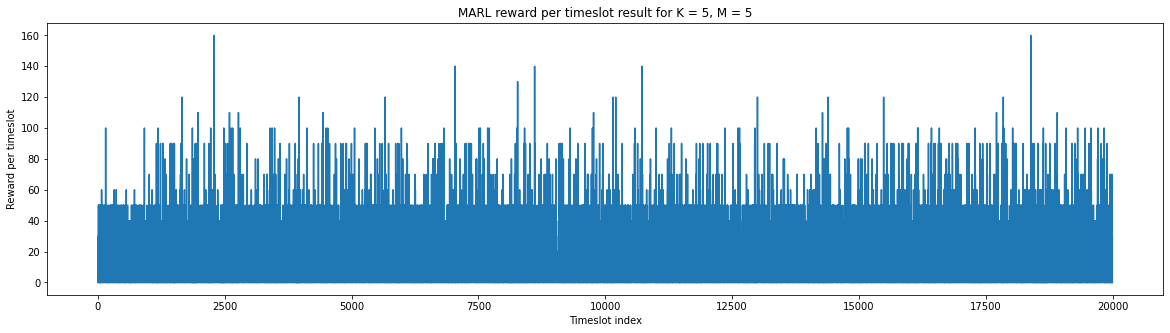

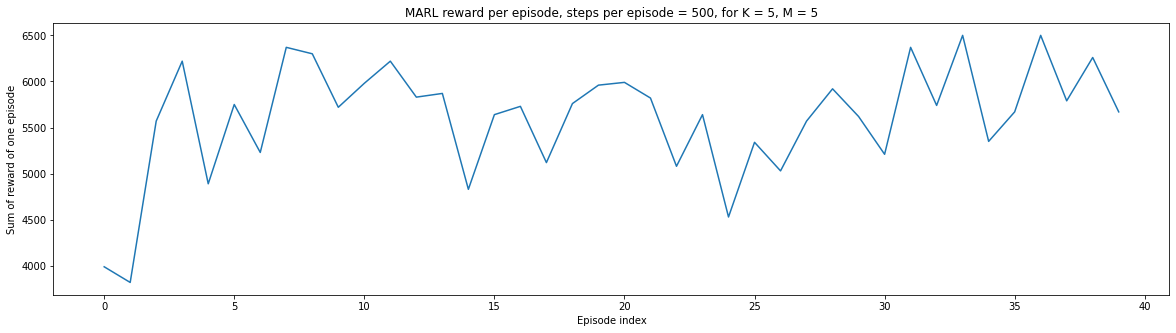

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Reward per timeslot')
plt.title('MARL reward per timeslot result for K = 5, M = 5')
plt.plot(marl_score)
plt.figure(figsize=(20,5))
plt.xlabel('Episode index')
plt.ylabel('Sum of reward of one episode')
plt.title('MARL reward per episode, steps per episode = 500, for K = 5, M = 5')
plt.plot(marl_reward_sum_history)

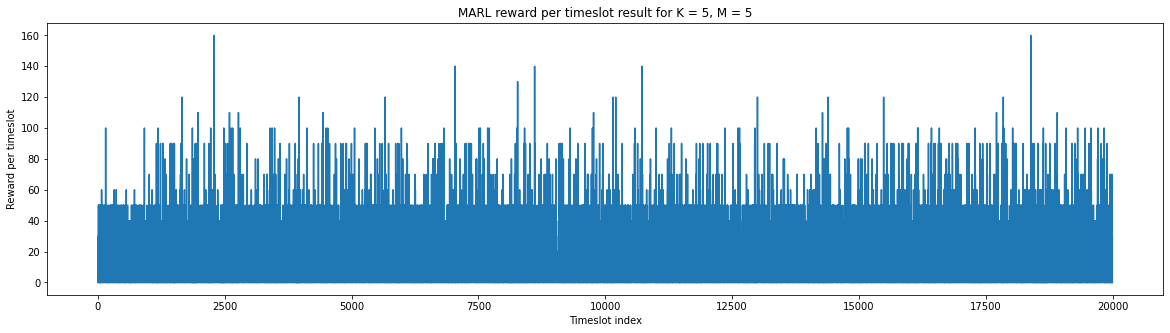

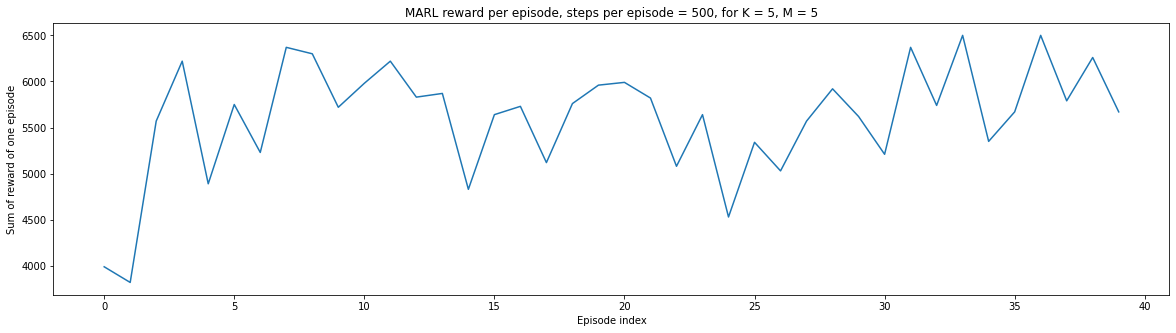

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Reward per timeslot')
plt.title('MARL reward per timeslot result for K = 5, M = 5')
plt.plot(marl_score)
plt.figure(figsize=(20,5))
plt.xlabel('Episode index')
plt.ylabel('Sum of reward of one episode')
plt.title('MARL reward per episode, steps per episode = 500, for K = 5, M = 5')
plt.plot(marl_reward_sum_history)

In [ ]:
for j in range(episode):

  reward_sum = 0

  env.process(rl_env.slot(counter,gen,agent1,agent2,agent3,agent4,agent5,marl_score,state,reward_sum,marl_reward_sum_history,a_r_history))
  env.run()


150108.0000 timelsot No. 08, task 4: resource not satisified, need resource 4, have resource 3
150128.0000 timelsot No. 10, task 4: resource not satisified, need resource 3, have resource 4
150128.0000 timelsot No. 10, task 4: resource not satisified, need resource 4, have resource 2
150138.0000 timelsot No. 11, task 4: resource not satisified, need resource 2, have resource 4
150138.0000 timelsot No. 11, task 4: resource not satisified, need resource 3, have resource 3
150138.0000 timelsot No. 11, task 4: resource not satisified, need resource 4, have resource 1
150138.0000 timelsot No. 11, task 4: resource not satisified, need resource 5, have resource 4
150178.0000 timelsot No. 15, task 4: resource not satisified, need resource 1, have resource 4
150178.0000 timelsot No. 15, task 4: resource not satisified, need resource 2, have resource 3
150178.0000 timelsot No. 15, task 4: resource not satisified, need resource 3, have resource 2
150178.0000 timelsot No. 15, task 4: resource not 

KeyboardInterrupt: ignored

##Single Agent classes

In [ ]:
class ReplayBuffer(object):
  def __init__(self,max_size,input_shape,input1,input2,n_actions):
    self.memsize = max_size
    self.mem_cntr = 0 
    self.state_memory = np.zeros((self.memsize,input1,input2))
    self.new_state_memory = np.zeros((self.memsize,input1,input2))
    self.action_memory = np.zeros((self.memsize), dtype= np.int8)
    self.reward_memory = np.zeros(self.memsize)


  def store_transistion(self,state,action,reward,newstate):
    index = self.mem_cntr % self.memsize
    self.state_memory[index] = state
    self.new_state_memory[index] = newstate
    self.action_memory[index] = action
    self.reward_memory[index] = reward
    self.mem_cntr += 1

  def sample_buffer(self,batch_size):
    max_mem = min(self.mem_cntr, self.memsize)
    batch = np.random.choice(max_mem,batch_size)

    states = self.state_memory[batch]
    new_states = self.new_state_memory[batch]
    actions = self.action_memory[batch]
    rewards = self.reward_memory[batch]
    return states,actions,rewards,new_states


In [ ]:

def create_q_model(lr, n_actions, input1,input2, fc1_dims, fc2_dims):
    # Network defined by the Deepmind paper
  model = Sequential([
                Flatten(input_shape=(input1,input2)),
                Dense(fc1_dims),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

  model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
  return model

In [ ]:
class Agent():
    def __init__(self, lr, gamma, n_actions, epsilon, batch_size, input_dims, input1,input2,mem_size=1000000,epsilon_dec=1e-3, epsilon_end=0.01, ):
        self.action_space = [i for i in range(2**M)]
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, input_dims,input1,input2,n_actions)
        self.q_eval = create_q_model(lr, n_actions, input1,input2, 256, 256)
        self.eps_dec = epsilon_dec
        self.eps_min = epsilon_end

    def store_transistion(self, state, action, reward, new_state):
        self.memory.store_transistion(state, action, reward, new_state)

    def choose_action(self, state,M):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
            #print("random action taken",action)
            #true = self.convert_RL_sim_action(action,M)

            return action
        else:
            #print(state,"is state for random action prediction")
            state = np.array([state])
            actions = self.q_eval.predict(state)

            action = np.argmax(actions)
            #print("action produced by Neural network")
            #t_action = self.convert_RL_sim_action(action)
            #true = self.convert_RL_sim_action(action,M)

            return action

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
          #dont learn because the replay buffer is not enough
          return

        states, actions, rewards, states_ = \
                self.memory.sample_buffer(self.batch_size)

        #output is bunch of actions
        #print(type(self.q_eval))
        q_eval = self.q_eval.predict(states) #calculate current state action
        q_next = self.q_eval.predict(states_) #calculate next state action


        q_target = np.copy(q_eval) #4 values with different weightings
        batch_index = np.arange(self.batch_size, dtype=np.int32)#
       # print(actions," is actions, ",actions.shape,"is actions shape",q_target.shape,"is q target shape")
        #update bellman's reward equation
        q_target[batch_index, actions] = rewards + \
                        self.gamma * np.max(q_next, axis=1)  #np.max determines the most likely action


        self.q_eval.train_on_batch(states, q_target)

        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > \
                self.eps_min else self.eps_min

    def save_model(self):
        self.q_eval.save(self.model_file)


    def load_model(self):
        self.q_eval = load_model(self.model_file)

In [ ]:
class RL_env(object):
  #aim of this class is to simulate a complete timeslot DES
  def __init__(self,env,num_timeslot,timeslot_duration,common_resource,counter):
    self.reward = 0 #reward per task
    self.rewards_per_slot = 0
    self.timeslot_duration = timeslot_duration
    self.common_resource = common_resource
    
    self.env = env
    self.counter = counter
    
    self.num_timeslot = num_timeslot
    self.timeslot_duration = timeslot_duration

  def slot(self,env, number, interval, counter, gen, agent, common_resource, slot_num, score, state, reward_sum, reward_sum_history):
    """timeslot,generate the arrival of M different tasks"""

    #every slot, reset rewards
    #print("rewards per slot and reward per task is resetted")
    #self.rewards_per_slot = 0
    #self.reward = 0
    #two for loop is necessary!!!!
    #interact_with_agent()
    for i in range(self.num_timeslot):
      self.rewards_per_slot = 0
      self.reward = 0
      agent_action,action = self.interact_with_agent_1(env,agent,state)
      for j in range(M):
        
        if gen[j]:  
          #print("generate tasks")
          self.env.process(  self.task_arrival(env, 'timelsot No. %02d, task %01d' % (i,j), self.counter,  action, common_resource, j) )
          name = 'timelsot No. %02d, task %01d' % (slot_num,j)

        #print('timelsot No. %02d, task %01d' % (slot_num,j)," is finished",env.now)
        #print('%7.4f %s: slot in process' % (env.now, name))
        else:
          pass
      #when generating each task is finished, yield time?
      yield self.env.timeout(interval)
      reward_sum += self.rewards_per_slot
      new_state,gen = self.interact_with_agent_2( env, agent,score, state,agent_action)
      state = new_state

    reward_sum_history.append(reward_sum)

    #print("rewards is :",self.rewards_per_slot,"reward ",self.reward)
    
    #yield self.env.timeout(interval) 
  
  def task_arrival(self, env, name, counter,  action, common_resource, m):
    """
    For a single task M, figure out whether to process it or not
    with action vector
    also need to return status of whether the task was sucessful or not
    """
    arrive = self.env.now
    #print('%7.4f %s: Task arrives' % (arrive, name))

    with counter.request() as req:  #performing certain a single task m

        #use action vector to check if this task
        allocate = True
        if action[m] == 0 :
          allocate = False
          #print('%7.4f %s: Action is not to process' % (env.now, name))

        if allocate:
          check = True
        
          #make use of action vector so that uncessary checks are obmitted
          for i in range(0,K):
            if common_resource[i].level < r[i,1]:
              #print('%7.4f %s: %1d %1d resource not satisfied for type: %1d'% (env.now,name, common_resource[i].level , r[i,1],i))
              print('%7.4f %s: resource not satisified, need resource %d, have resource %d' % (env.now, name,r[i,1],common_resource[i].level))
              check = False
              self.reward = 0

        
          """Starts processing if resource requiremenet is satisfied"""
          if check == True:
            
            for i in range (0,K):
              common_resource[i].get(r[i,1])#occupies the resource for processing
            #determines the length of processing
            tib = np.random.geometric(Beta[m])
            #t = 11
            yield env.timeout(tib)
            #print('%7.4f %s: Finished Processing' % (env.now, name))
            self.reward = U[m] #sucessfully allocated
            self.rewards_per_slot += self.reward
            #print("reward is:",self.reward)
            for i in range (0,K):
              yield common_resource[i].put(r[i,1])#release the resources
            #time_left
            #print('%7.4f %s: Task resource released' % (env.now, name))
            
          

          else:
            #the resource does not satisfy, don't do this task.
            self.reward = 0 #sucessfully allocated
            yield env.timeout(0)

            #print('%7.4f %s: allocation failed' % (env.now, name))


  def interact_with_agent_1(self, env, agent, state):

    agent_action = agent.choose_action(state,M) #returns the action that can be interpreted in simpy!! carefull  
    true_action = convert_RL_sim_action(agent_action,M)
    return agent_action, true_action
    
    #tmp = env.process(self.slot(env,num_timeslot,timeslot_duration,counter,gen,true_action,common,i))

    
    
  
  def interact_with_agent_2(self, env, agent,score,state,agent_action):
    #state = 0
    eps_history.append(agent.epsilon)
    #env.run() executed in the main program

    reward = rl_env.rewards_per_slot
    
    #print(reward," is reward for timeslot")
    
    #print("One timesloot is finished, can produce state, action, reward",env.now)
    """Calculate state,action,reward. need to call state_gen for the new states."""
    new_state,gen = state_gen(Beta,M,r,common)
    #score += reward
    #print("step",i)
    score.append(reward)
    agent.store_transistion(state,agent_action,reward,new_state)
    
    agent.learn()
    state = new_state
    
    return state,gen

###execution program

1240.0000 timelsot No. 124, task 2: resource not satisified, need resource 5, have resource 0
1350.0000 timelsot No. 135, task 4: resource not satisified, need resource 5, have resource 0
2170.0000 timelsot No. 217, task 4: resource not satisified, need resource 5, have resource 0
3580.0000 timelsot No. 358, task 2: resource not satisified, need resource 5, have resource 0
3910.0000 timelsot No. 391, task 3: resource not satisified, need resource 5, have resource 0
3920.0000 timelsot No. 392, task 4: resource not satisified, need resource 5, have resource 0
5860.0000 timelsot No. 86, task 3: resource not satisified, need resource 5, have resource 0
6030.0000 timelsot No. 103, task 1: resource not satisified, need resource 5, have resource 0
7020.0000 timelsot No. 202, task 1: resource not satisified, need resource 5, have resource 0
8220.0000 timelsot No. 322, task 4: resource not satisified, need resource 5, have resource 0
11470.0000 timelsot No. 147, task 2: resource not satisified,

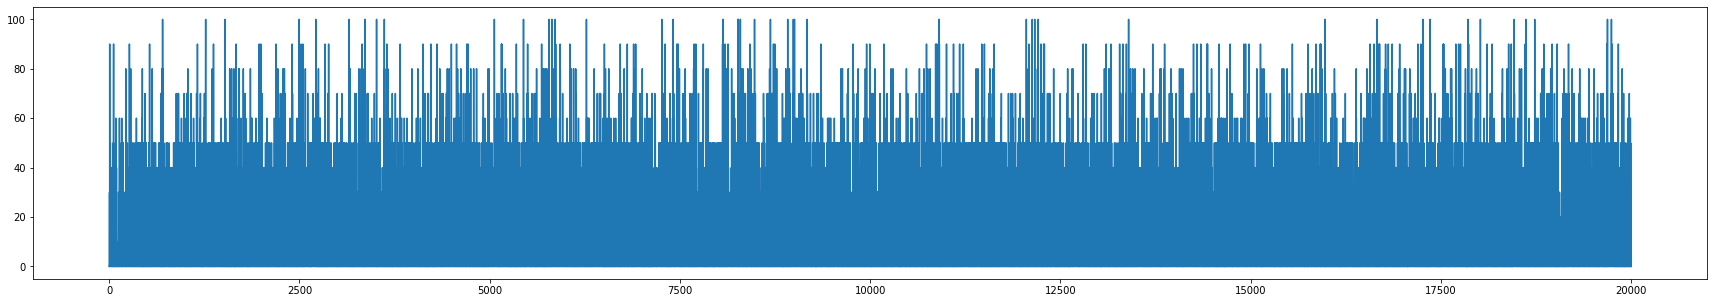

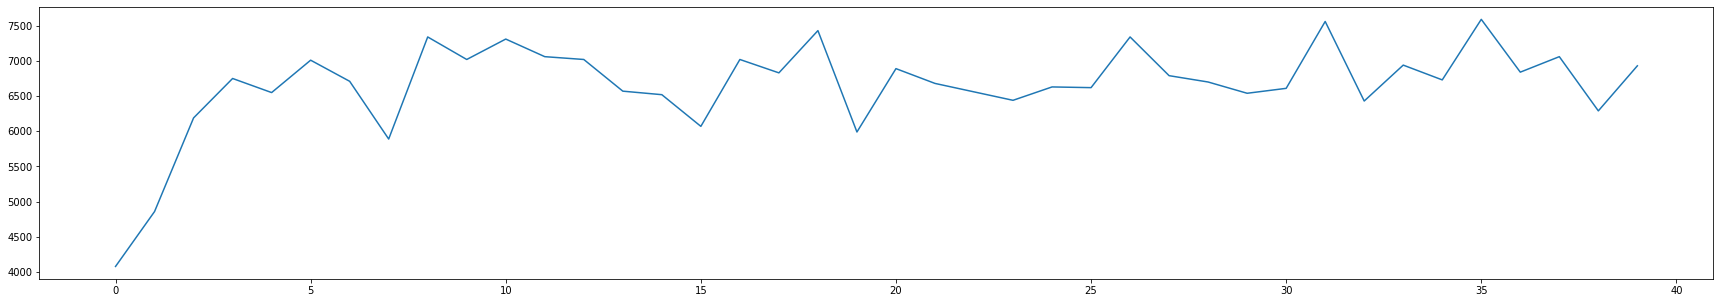

In [ ]:


random.seed(RANDOM_SEED)

env = simpy.Environment()
#num_timeslot = 5
#timeslot_duration = 10

#num_timeslot = 500
#num_timeslot_per_episode = 500
#episode = 40


#establishing common resources C_k
common = []
for i in range(0,len(C_k)):
  tmp = simpy.Container(env, C_k[i], init=C_k[i])
  common.append(tmp)


  # Start processes and run
counter = simpy.Resource(env, capacity=3*M) #for processing M different tasks
state,gen = state_gen(Beta,M,r,common)

#initializing environment

agent = Agent(lr= 0.001,gamma = 0.9, n_actions = 2**M, epsilon = 0.9,epsilon_dec=1e-3, epsilon_end=0.01, batch_size=64,
                input_dims = (M+1)*K, input1=M+1,input2=K, mem_size=500)
  
eps_history = []
rl_env = RL_env(env,num_timeslot,timeslot_duration,common,counter)
  
score = []
average_reward_per_episode = 0
reward_sum_history=[]

#running the simulation

for j in range(episode):

  reward_sum = 0

  env.process(rl_env.slot(env,num_timeslot,timeslot_duration,counter,gen,agent,common,i,score,state,reward_sum,reward_sum_history))


  env.run()

  #reward_sum_per_episode.append(reward_sum)
plt.figure(figsize=(30,5))
plt.plot(score)
plt.figure(figsize=(30,5))
plt.plot(reward_sum_history)

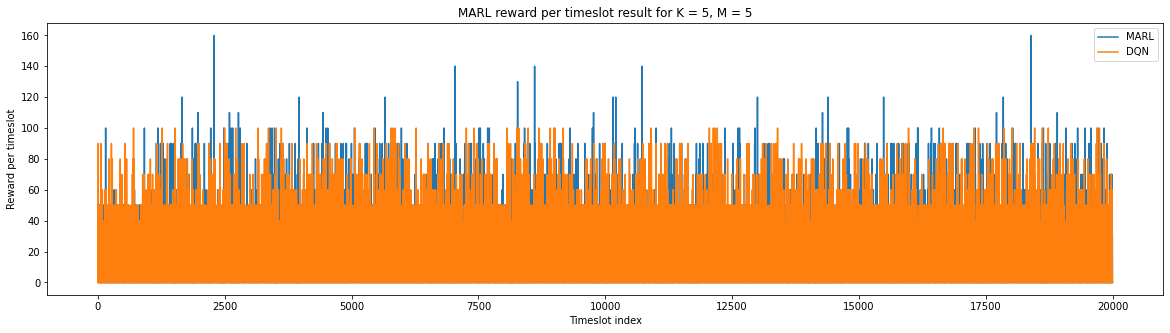

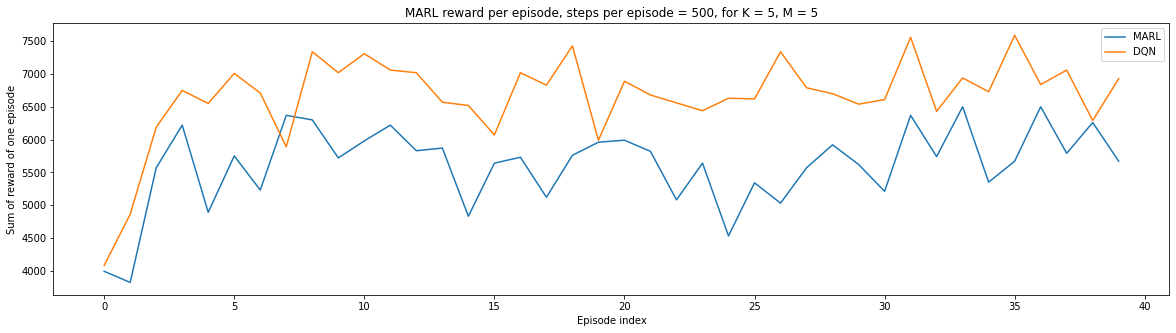

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Reward per timeslot')
plt.title('MARL reward per timeslot result for K = 5, M = 5')
plt.plot(marl_score,label='MARL')
plt.plot(score,label='DQN')
plt.legend()
plt.figure(figsize=(20,5))
plt.xlabel('Episode index')
plt.ylabel('Sum of reward of one episode')
plt.title('MARL reward per episode, steps per episode = 500, for K = 5, M = 5')
plt.plot(marl_reward_sum_history,label='MARL')
plt.plot(reward_sum_history,label='DQN')
plt.legend()

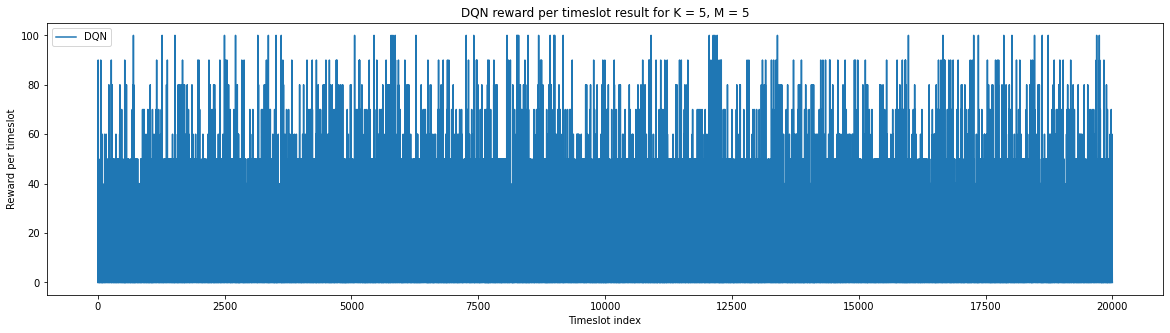

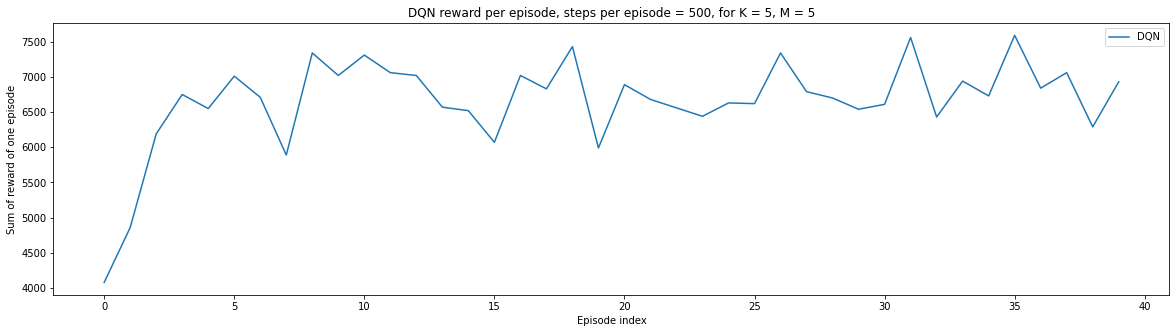

In [ ]:
plt.figure(figsize=(20,5))
plt.xlabel('Timeslot index')
plt.ylabel('Reward per timeslot')
plt.title('DQN reward per timeslot result for K = 5, M = 5')
#plt.plot(marl_score[0:15000],label='MARL')
plt.plot(score,label='DQN')
plt.legend()
plt.figure(figsize=(20,5))
plt.xlabel('Episode index')
plt.ylabel('Sum of reward of one episode')
plt.title('DQN reward per episode, steps per episode = 500, for K = 5, M = 5')
#plt.plot(marl_reward_sum_history[0:30],label='MARL')
plt.plot(reward_sum_history,label='DQN')
plt.legend()

In [ ]:
reward_sum_history[15]

7130